# Cookbook: Every way to make a `Molecule`

Every pathway through the OpenFF Toolkit boils down to four steps:

1. Using other tools, assemble a graph of a molecule, including all of its atoms, bonds, bond orders, formal charges, and stereochemistry[^rs]
2. Use that information to construct a [`Molecule`](openff.toolkit.topology.Molecule)
3. Combine a number of `Molecule` objects to construct a [`Topology`](openff.toolkit.topology.Topology)
4. Call [`ForceField.create_openmm_system(topology)`](openff.toolkit.typing.engines.smirnoff.forcefield.ForceField.create_openmm_system) to create an OpenMM [`System`](simtk.openmm.openmm.System) (or, in the near future, an OpenFF [`Interchange`](https://github.com/openforcefield/openff-interchange) for painless conversion to all sorts of MD formats)

So let's take a look at every way there is to construct a molecule! We'll use zwitterionic L-alanine as an example biomolecule with all the tricky bits - a stereocenter, non-zero formal charges, and bonds of different orders.

[^rs]: Note that this stereochemistry must be defined on the *graph* of the molecule. It's not good enough to just co-ordinates with the correct stereochemistry. But if you have the co-ordinates, you can try getting the stereochemistry automatically with `rdkit` or `openeye` --- If you dare!

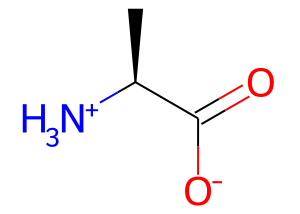

In [1]:
# Imports
from openff.toolkit.topology import Molecule, Topology
from openff.toolkit.typing.engines.smirnoff import ForceField

# Hide tracebacks for simpler errors
import sys
ipython = get_ipython()

def hide_traceback(exc_tuple=None, filename=None, tb_offset=None,
                   exception_only=False, running_compiled_code=False):
    etype, value, tb = sys.exc_info()
    value.__cause__ = None  # suppress chained exceptions
    return ipython._showtraceback(etype, value, ipython.InteractiveTB.get_exception_only(etype, value))

ipython.showtraceback = hide_traceback

# Show us alanine
zw_l_alanine = Molecule.from_smiles("C[C@H]([NH3+])C([O-])=O")

from IPython.display import SVG
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.rdmolops import RemoveHs
from rdkit.Chem.Draw import rdDepictor
rdDepictor.SetPreferCoordGen(True)

def visualize(mol, width=300, height=None):
    if height is None:
        height = int(width * 5/7)
    rdmol = RemoveHs(mol.to_rdkit())
    rdDepictor.Compute2DCoords(rdmol)
    
    drawer = rdMolDraw2D.MolDraw2DSVG(width, height)
    drawer.DrawMolecule(rdmol)
    drawer.FinishDrawing()
    
    return SVG(drawer.GetDrawingText())


visualize(zw_l_alanine)

## From SMILES

SMILES is the classic way to create a `Molecule`. SMILES is a widely-used compact textual representation of arbitrary molecules. This lets us specify an exact molecule, including stereochemistry and bond orders, very easily --- though they may not be the most human-readable format.

The [`Molecule.from_smiles()`](openff.toolkit.topology.Molecule.from_smiles) method is used to create a `Molecule` from a SMILES code.

### Implicit hydrogens SMILES

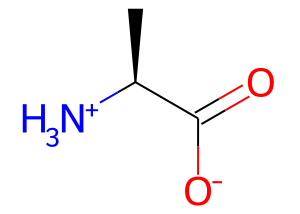

In [2]:
smiles_implicit_h = Molecule.from_smiles("C[C@H]([NH3+])C(=O)[O-]")

assert zw_l_alanine.is_isomorphic_with(smiles_implicit_h)

visualize(smiles_implicit_h)

### Explicit hydrogens SMILES

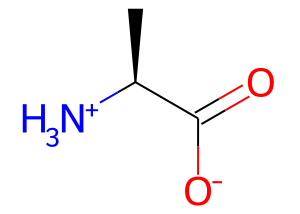

In [3]:
smiles_explicit_h = Molecule.from_smiles(
    "[H][C]([H])([H])[C@@]([H])([C](=[O])[O-])[N+]([H])([H])[H]", 
    hydrogens_are_explicit=True
)

assert zw_l_alanine.is_isomorphic_with(smiles_explicit_h)

visualize(smiles_explicit_h)

### Mapped SMILES

By default, no guarantees are made about the indexing of atoms from a SMILES string. If the indexing is important, a mapped SMILES string may be used. In this case, Hydrogens must be explicit. Note that though mapped SMILES strings must start at index 1, Python lists start at index 0.

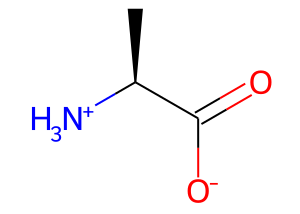

In [128]:
mapped_smiles = Molecule.from_mapped_smiles(
    "[H:10][C:2]([H:7])([H:8])[C@@:4]([H:9])([C:3](=[O:5])[O-:6])[N+:1]([H:11])([H:12])[H:13]"
)

assert zw_l_alanine.is_isomorphic_with(mapped_smiles)

assert mapped_smiles.atoms[0].atomic_number == 7 # First index is the Nitrogen
assert all([a.atomic_number==1 for a in mapped_smiles.atoms[6:]]) # Final indices are all H

visualize(mapped_smiles)

### SMILES without stereochemistry

The Toolkit won't accept an ambiguous SMILES. This SMILES could be L- or D- alanine; rather than guess, the Toolkit throws an error:

In [5]:
smiles_non_isomeric = Molecule.from_smiles(
    "CC([NH3+])C(=O)[O-]"
)

UndefinedStereochemistryError: Unable to make OFFMol from RDMol: Unable to make OFFMol from SMILES: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 1)


We can downgrade this error to a warning with the `allow_undefined_stereo` argument. This will not apply an improper dihedral term to the stereocenter and may lead to simulations with unphysical stereoisomerisation.

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 1)



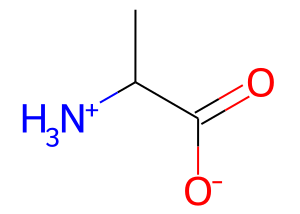

In [6]:
smiles_non_isomeric = Molecule.from_smiles(
    "CC([NH3+])C(=O)[O-]",
    allow_undefined_stereo=True
)

assert not zw_l_alanine.is_isomorphic_with(smiles_non_isomeric)

visualize(smiles_non_isomeric)

## By hand

You can always construct a `Molecule` by building it up from individual atoms and bonds. Other methods are generally easier, but it's a useful fallback for when you need to write your own constructor for an unsupported source format.

The [`Molecule()`](openff.toolkit.topology.Molecule.__init__) constructor and the [`add_atom()`](openff.toolkit.topology.Molecule.add_atom) and [`add_bond()`](openff.toolkit.topology.Molecule.add_bond) methods are used to construct a `Molecule` by hand.

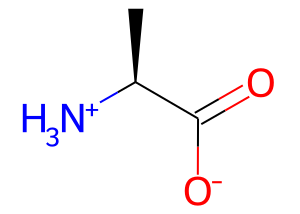

In [7]:
by_hand = Molecule()
by_hand.name = "Zwitterionic l-Alanine"

by_hand.add_atom(
    atomic_number = 8, # Atomic number 8 is Oxygen
    formal_charge = -1, # Formal negative charge
    is_aromatic = False, # Atom is not part of an aromatic system
    stereochemistry = None, # Optional argument; "R" or "S" stereochemistry
    name = "O-" # Optional argument; descriptive name for the atom
)
by_hand.add_atom(6,  0, False, name="C")
by_hand.add_atom(8,  0, False, name="O")
by_hand.add_atom(6,  0, False, stereochemistry="S", name="CA")
by_hand.add_atom(1,  0, False, name="CAH")
by_hand.add_atom(6,  0, False, name="CB")
by_hand.add_atom(1,  0, False, name="HB1")
by_hand.add_atom(1,  0, False, name="HB2")
by_hand.add_atom(1,  0, False, name="HB3")
by_hand.add_atom(7, +1, False, name="N+")
by_hand.add_atom(1,  0, False, name="HN1")
by_hand.add_atom(1,  0, False, name="HN2")
by_hand.add_atom(1,  0, False, name="HN3")


by_hand.add_bond( 
    atom1 = 0, # First (zero-indexed) atom specified above ("O-")  
    atom2 = 1, # Second atom specified above ("C")
    bond_order = 1, # Single bond
    is_aromatic = False, # Bond is not aromatic
    stereochemistry = None, # Optional argument; "E" or "Z" stereochemistry
    fractional_bond_order = None # Optional argument; Wiberg (or similar) bond order
)
by_hand.add_bond( 1,  2, 2, False) # C = O
by_hand.add_bond( 1,  3, 1, False) # C - CA
by_hand.add_bond( 3,  4, 1, False) # CA - CAH
by_hand.add_bond( 3,  5, 1, False) # CA - CB
by_hand.add_bond( 5,  6, 1, False) # CB - HB1
by_hand.add_bond( 5,  7, 1, False) # CB - HB2
by_hand.add_bond( 5,  8, 1, False) # CB - HB3
by_hand.add_bond( 3,  9, 1, False) # CB - N+
by_hand.add_bond( 9, 10, 1, False) # N+ - HN1
by_hand.add_bond( 9, 11, 1, False) # N+ - HN2
by_hand.add_bond( 9, 12, 1, False) # N+ - HN3

assert zw_l_alanine.is_isomorphic_with(by_hand)

visualize(by_hand)

## From a file

We can construct a `Molecule` from a file or file-like object with the [`from_file()`](openff.toolkit.topology.Molecule.from_file) method. We're a bit constrained in what file formats we can accept, because they need to provide all the information needed to construct the molecular graph; not just coordinates, but also elements, formal charges, bond orders, and stereochemistry.

### From SDF file

We generally recommend the SDF format.

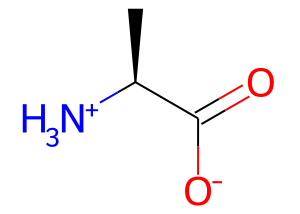

In [8]:
sdf_path = Molecule.from_file("zw_l_alanine.sdf")
assert zw_l_alanine.is_isomorphic_with(sdf_path)
visualize(sdf_path)

### From SDF file object

`from_file()` can also take a file object, rather than a path. Note that the object must be in binary mode!

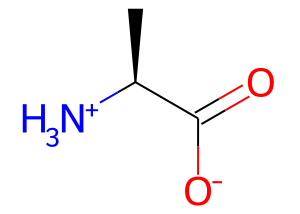

In [9]:
with open("zw_l_alanine.sdf", mode="rb") as file:
    sdf_object = Molecule.from_file(file, file_format="SDF")
    
assert zw_l_alanine.is_isomorphic_with(sdf_object)
visualize(sdf_object)

### From PDB file

PDB files cannot be supported, even if they have CONECT records, as they do not provide stereoisomeric information or bond orders.

<!-- RDKIT assumes PDB bond orders are 1, so we don't use it, OpenEye can guess bond orders but can make mistakes -->

In [10]:
pdb = Molecule.from_file("zw_l_alanine.pdb", "pdb")

NotImplementedError: No toolkits in registry can read file zw_l_alanine.pdb (format PDB). Supported formats in the provided ToolkitRegistry are {'The RDKit': ['SDF', 'MOL', 'SMI'], 'AmberTools': [], 'Built-in Toolkit': []}. RDKit can not safely read PDBs on their own. Information about bond order and aromaticity is likely to be lost. PDBs can be used along with a valid smiles string with RDKit using the constructor Molecule.from_pdb_and_smiles(file_path, smiles)

If we provide a SMILES code, a PDB file can be used to populate the `Molecule` object's `conformers` attribute and provide atom ordering, as well as check that the SMILES code matches the PDB file. The warning provided is [spurious](https://github.com/openforcefield/openff-toolkit/issues/1000).

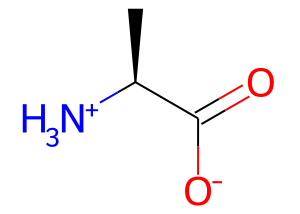

In [11]:
pdb_with_smiles = Molecule.from_pdb_and_smiles(
    "zw_l_alanine.pdb", 
    "C[C@H]([NH3+])C(=O)[O-]"
)  

assert zw_l_alanine.is_isomorphic_with(pdb_with_smiles)

visualize(pdb_with_smiles)

## Other string identification formats

The OpenFF Toolkit supports a few text based molecular identity formats other than SMILES ([see above](#from-smiles))

### From InChI

The [`Molecule.from_inchi()`](openff.toolkit.topology.Molecule.from_inchi) method constructs a `Molecule` from an IUPAC [InChI](https://iupac.org/who-we-are/divisions/division-details/inchi/) string. Note that InChI cannot distinguish the zwitterionic form of alanine from the neutral form (see section 13.2 of the [InChI Technical FAQ](https://www.inchi-trust.org/technical-faq-2/)), so the toolkit defaults to the neutral form.

:::{warning}
The OpenFF Toolkit makes no guarantees about the atomic ordering produced by the `from_inchi` method. InChI is not intended to be an interchange format.
:::

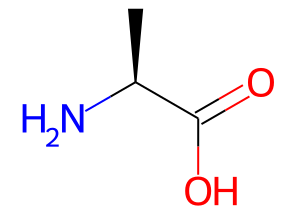

In [146]:
inchi = Molecule.from_inchi("InChI=1S/C3H7NO2/c1-2(4)3(5)6/h2H,4H2,1H3,(H,5,6)/t2-/m0/s1")  

visualize(inchi)

### From IUPAC name

The [`Molecule.from_iupac()`](openff.toolkit.topology.Molecule.from_iupac) method constructs a `Molecule` from an IUPAC name.

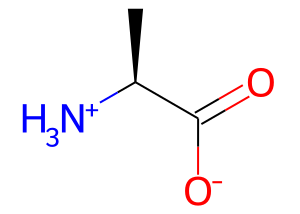

In [147]:
iupac = Molecule.from_iupac("(2S)-2-azaniumylpropanoate")

assert zw_l_alanine.is_isomorphic_with(iupac)

visualize(iupac)

## Remapping an existing `Molecule`

Most `Molecule` creation methods don't specify the ordering of atoms in the new `Molecule`. The [`Molecule.remap()`](openff.toolkit.topology.Molecule.remap) method allows a new ordering to be applied to an existing `Molecule`.

See also [Mapped SMILES](#mapped-smiles).

:::{warning}
The `Molecule.remap()` method is experimental and subject to change. 
:::

Before remapping: [H:3][C@@:2]([C:5](=[O:7])[O-:6])([C:1]([H:8])([H:9])[H:10])[N+:4]([H:11])([H:12])[H:13]
After remapping:  [H:3][C@@:2]([C:5](=[O:6])[O-:7])([C:1]([H:8])([H:9])[H:10])[N+:4]([H:11])([H:12])[H:13]


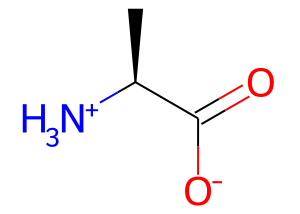

In [138]:
# Note that this mapping is off-by-one from the mapping taken 
# by the remap method, as Python indexing is 0-based but SMILES
# is 1-based
print("Before remapping:", zw_l_alanine.to_smiles(mapped=True))

# Flip the positions of the oxygen atoms
remapped = zw_l_alanine.remap({0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 6, 6: 5, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12})

print("After remapping: ", remapped.to_smiles(mapped=True))

# Doesn't affect the identity of the molecule
assert zw_l_alanine.is_isomorphic_with(remapped)
visualize(remapped)

## Via `Topology` objects

The [`Topology`](openff.toolkit.topology.Topology) class represents a biomolecular system; it is analogous to the similarly named objects in GROMACS, MDTraj or OpenMM. Notably, it does not include co-ordinates and may represent multiple copies of a particular molecular species or even more complex mixtures of molecules. `Topology` objects are usually built up one species at a time from `Molecule` objects.

The [`Molecule.from_topology()`](openff.toolkit.topology.Molecule.from_topology) method constructs a `Molecule` from a `Topology`. This is usually going backwards, but the method does allow construction of `Molecule` objects from a few sources that represent molecular mixtures, like the aforementioned `Topology` or `System`.

- Things that go through Topology, and you actually need to know the GRAPH of the molecule ahead of time (they require a unique_molecules keyword argument with the full identity of the molecules to run). This really just reorders the atoms to be in the other object’s order:

    - [ ] Topology.from_openmm (add’l step mol=topology.reference_molecules[0])

    - [ ] Topology.from_mdtraj (add’l step mol=topology.reference_molecules[0])

### From an OpenMM `Topology`

The [`Topology.from_openmm()`](openff.toolkit.topology.Topology.from_openmm) method constructs an OpenFF `Topology` from an OpenMM [`Topology`](simtk.openmm.app.topology.Topology). The method requires that all the unique molecules in the `Topology` are provided as OpenFF `Molecule` objects, as the structure of an OpenMM `Topology` doesn't include the concept of a molecule. When using this method to create a `Molecule`, this limitation means that the method really only offers a pathway to reorder the atoms of a `Molecule` to match that of the OpenMM `Topology`.

## From Toolkit objects

The OpenFF Toolkit calls out to other software to perform low-level tasks like reading SMILES or files. These external software packages are called toolkits, and presently include [RDKit](https://www.rdkit.org/) and the [OpenEye Toolkit](https://www.eyesopen.com/toolkit-development). OpenFF `Molecule` objects can be created from the equivalent objects in these toolkits.

### From RDKit `Mol`

The [`Molecule.from_rdkit()`](openff.toolkit.topology.Molecule.from_rdkit) method converts an [`rdkit.Chem.rdchem.Mol`](rdkit.Chem.rdchem.Mol) object to an OpenFF `Molecule`.

rdmol is of type <class 'rdkit.Chem.rdchem.Mol'>


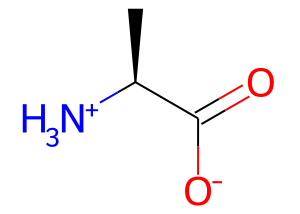

In [17]:
from rdkit import Chem
rdmol = Chem.MolFromSmiles("C[C@H]([NH3+])C([O-])=O")

print("rdmol is of type", type(rdmol))

from_rdmol = Molecule.from_rdkit(rdmol)

assert zw_l_alanine.is_isomorphic_with(from_rdmol)
visualize(from_rdmol)

### From OpenEye `OEMol`

The [`Molecule.from_openeye()`](openff.toolkit.topology.Molecule.from_rdkit) method converts an object that inherits from [`openeye.oechem.OEMolBase`](https://docs.eyesopen.com/toolkits/python/oechemtk/OEChemClasses/OEMolBase.html) to an OpenFF `Molecule`.

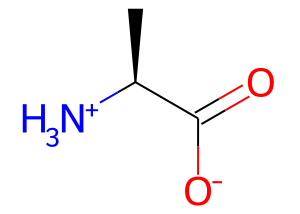

In [15]:
from openeye import oechem

oemol = oechem.OEGraphMol()
oechem.OESmilesToMol(oemol, "C[C@H]([NH3+])C([O-])=O")

assert isinstance(oemol, oechem.OEMolBase)

from_oemol = Molecule.from_openeye(oemol)

assert zw_l_alanine.is_isomorphic_with(from_oemol)
visualize(from_oemol)

## From QCArchive

[QCArchive](https://qcarchive.molssi.org/) is a repository of quantum chemical calculations on small molecules. The [`Molecule.from_qcschema()`](openff.toolkit.topology.Molecule.from_qcschema) method creates a `Molecule` from a record from the archive. Because the identity of a molecule can change of the course of a QC calculation, the Toolkit accepts records only if they contain a hydrogen-mapped SMILES code.

### From a QCArchive molecule record

In [237]:
from qcportal import FractalClient

client = FractalClient()
qc_mols = client.query_molecules(molecular_formula="C3H7NO2", limit=1)

from_qc_mol = Molecule.from_qcschema(qc_mols[0])

visualize(from_qc_mol)

KeyError: "The record must contain the hydrogen mapped smiles to be safely made from the archive. It is not present in either 'attributes' or 'extras' on the provided `qca_record`"

# TODO

Several of these methods do not exist in the Molecule class. I have styled them with ~~strikethroughs~~

- [x] “Molecules should have explicit hydrogens, bond orders, formal charges, stereochemistry (defined on GRAPH, not just 3D)”

- [x] Molecule.add_atom and Molecule.add_bond

- [x] from_file

- [x] ~~from_file_obj~~ <!-- This method exists on ToolkitWrapper, but not Molecule -->

- [x] ~~from_object~~, which really delegates to:

    from_rdkit

    from_openeye

- [x] from_smiles

- [x] from_mapped_smiles

- [ ] from_qcschema

- [x] offmol.remap (instance method)

- [ ] from_topology

- [x] from_inchi – “InChI is not intended to be an interchange format” NOTE THAT THIS DOESN’T PRESERVE ATOM ORDER!!

- [x] from_iupac (requires OpenEye)

- Things that go through Topology, and you actually need to know the GRAPH of the molecule ahead of time (they require a unique_molecules keyword argument with the full identity of the molecules to run). This really just reorders the atoms to be in the other object’s order:

    - [ ] Topology.from_openmm (add’l step mol=topology.reference_molecules[0])

    - [ ] Topology.from_mdtraj (add’l step mol=topology.reference_molecules[0])

- [x] Molecule.from_pdb_and_smiles 

- [ ] Molecule.from_dict() (which underlies from_ bson, json, toml, messagepack, yaml, pickle, etc)